In [1]:
import tensorflow as tf
import os


DATA_DIR = 'dataset/car-segmentation'

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [2]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


2025-08-24 17:03:55.038511: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-08-24 17:03:55.038538: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-08-24 17:03:55.038542: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1756029835.038553 47107929 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1756029835.038572 47107929 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 211
Training examples: 168
Validation examples: 43


In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [5]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [6]:
BATCH_SIZE = 32
BUFFER_SIZE = 200 

In [7]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [8]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2025-08-24 17:03:55.154664: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:55.242587: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:55.599461: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:56.030357: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:56.037583: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:56.563923: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:03:56.709049: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile



--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


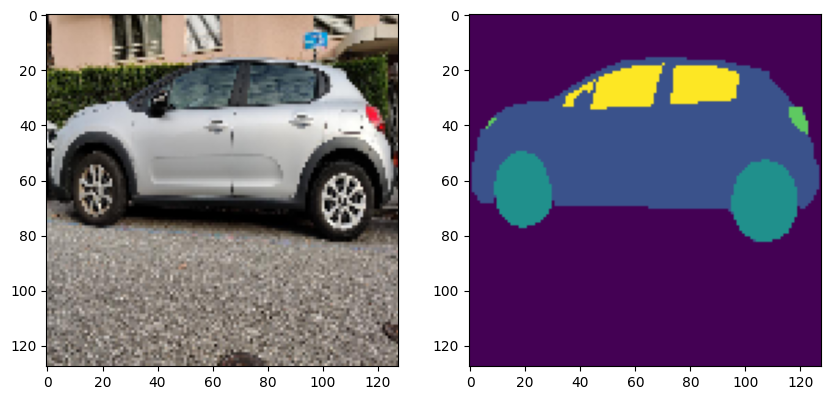

In [9]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0
    
    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()

    

In [10]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)
        
print(color_value_list) 

[0 1 2 3 4]
{0, 1, 2, 3, 4}


## Build the U-Net Model


In [11]:
from tensorflow.keras import layers

def conv_block(input_tensor, num_filters):
    """A block of two 3x3 convolutions, each followed by ReLU."""
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    return x



In [12]:
def encoder_block(input_tensor, num_filters):
    """Convolution block followed by max pooling."""
    skip_connection = conv_block(input_tensor, num_filters)
    pool = layers.MaxPooling2D((2, 2))(skip_connection)
    return skip_connection, pool

In [13]:
def decoder_block(input_tensor, skip_tensor, num_filters):
    """Up-convolution, concatenation with skip connection, and a conv block."""
    up_conv = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    concatenated = layers.concatenate([up_conv, skip_tensor])
    x = conv_block(concatenated, num_filters)
    return x

In [14]:
def build_unet(input_shape, num_classes):

    
    """Build the U-Net model."""
    inputs = layers.Input(shape=input_shape)


     # --- Encoder Path ---
    s1, p1 = encoder_block(inputs, 64)   # 128x128 -> 64x64
    s2, p2 = encoder_block(p1, 128)      # 64x64 -> 32x32
    s3, p3 = encoder_block(p2, 256)      # 32x32 -> 16x16
    s4, p4 = encoder_block(p3, 512)      # 16x16 -> 8x8


    bottleneck = conv_block(p4, 1024)    # 8x8

     # --- Decoder Path ---
    d1 = decoder_block(bottleneck, s4, 512) # 8x8 -> 16x16
    d2 = decoder_block(d1, s3, 256)         # 16x16 -> 32x32
    d3 = decoder_block(d2, s2, 128)         # 32x32 -> 64x64
    d4 = decoder_block(d3, s1, 64)          # 64x64 -> 128x128


    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(d4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
NUM_CLASSES = 5
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet(input_shape, NUM_CLASSES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,032,005 (118.38 MB)

 Trainable params: 31,032,005 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

5


### Visualize Model Architecture

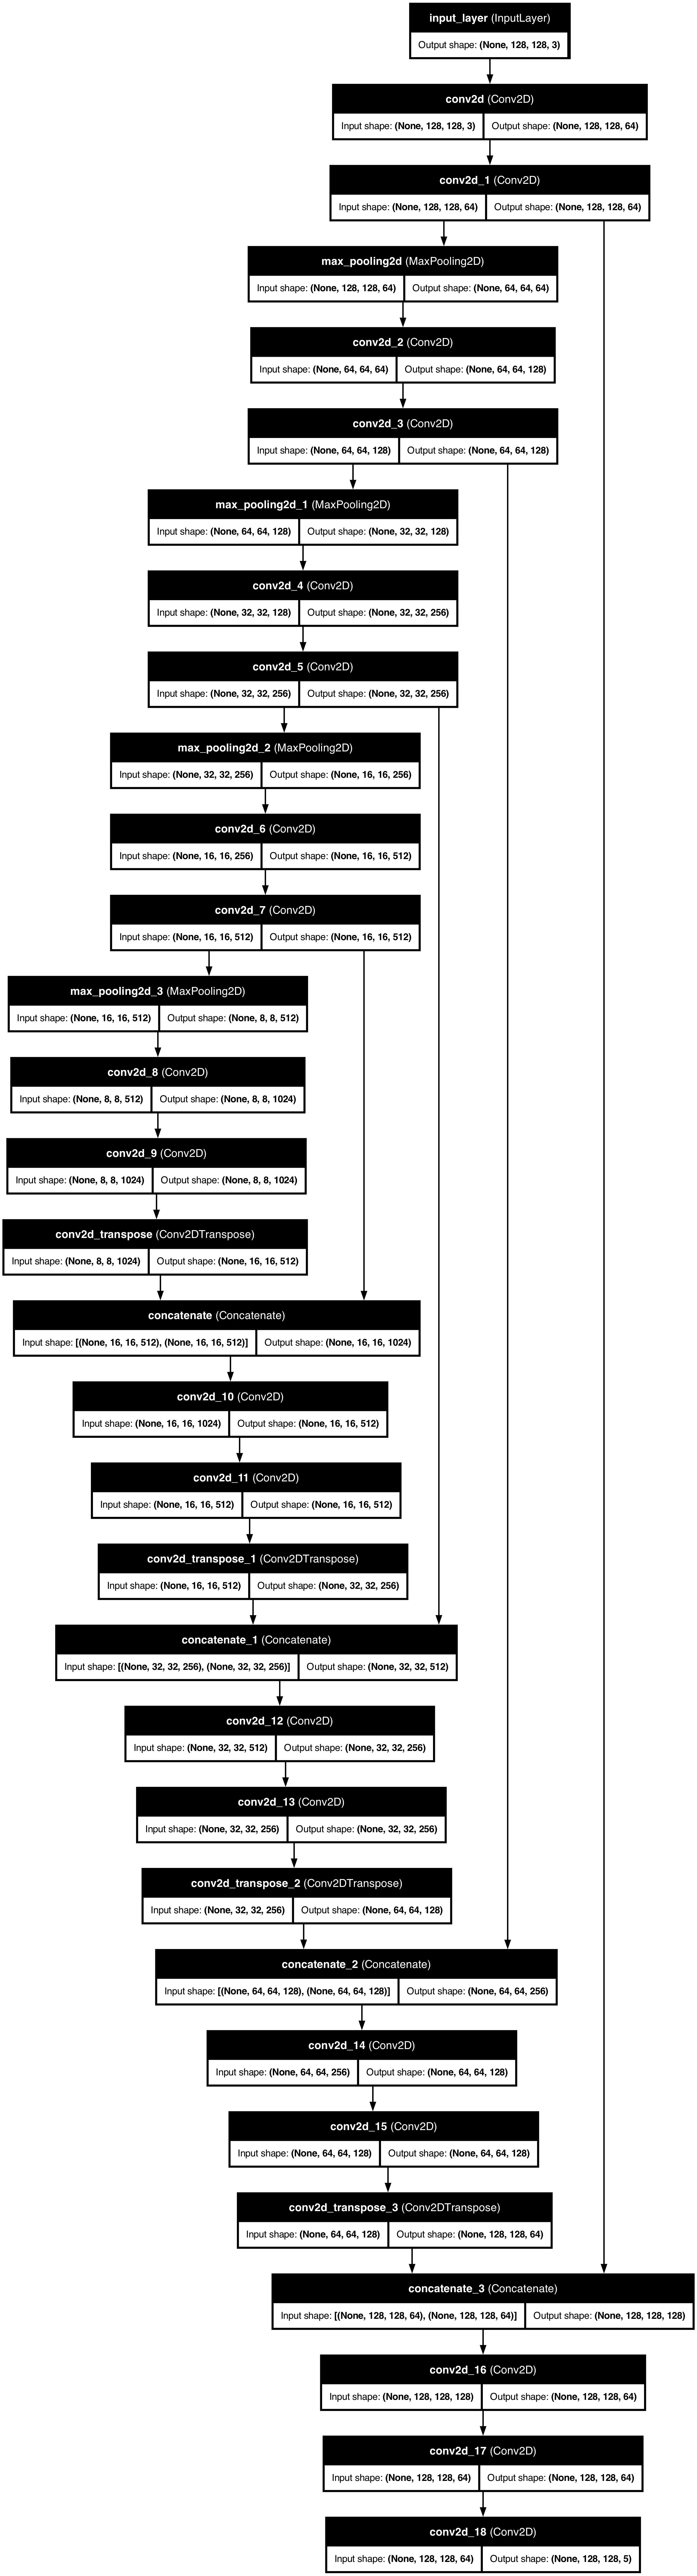

In [18]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

In [19]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/20


2025-08-24 17:04:55.708997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5655 - loss: 1.6132

2025-08-24 17:05:01.496693: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:01.535810: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 768ms/step - accuracy: 0.5730 - loss: 1.6183 - val_accuracy: 0.6461 - val_loss: 1.2495 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6536 - loss: 1.2079

2025-08-24 17:05:04.725991: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - accuracy: 0.6523 - loss: 1.2034 - val_accuracy: 0.2825 - val_loss: 2.0636 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.4528 - loss: 1.5105 - val_accuracy: 0.6780 - val_loss: 0.9602 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6625 - loss: 0.9745

2025-08-24 17:05:10.372069: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:10.373380: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:10.416711: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.6616 - loss: 0.9759 - val_accuracy: 0.7009 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6453 - loss: 0.9618

2025-08-24 17:05:13.299847: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - accuracy: 0.6464 - loss: 0.9608 - val_accuracy: 0.6427 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6444 - loss: 0.9405

2025-08-24 17:05:16.042628: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:16.052161: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:16.055375: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:16.079119: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:16.096307: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:16.111278: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.6440 - loss: 0.9419 - val_accuracy: 0.6445 - val_loss: 0.9533 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6439 - loss: 0.9284

2025-08-24 17:05:19.242757: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:19.269221: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - accuracy: 0.6449 - loss: 0.9274 - val_accuracy: 0.6328 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6411 - loss: 0.9035

2025-08-24 17:05:22.030091: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:22.070863: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 0.6427 - loss: 0.9029 - val_accuracy: 0.6764 - val_loss: 0.8701 - learning_rate: 2.0000e-04
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6490 - loss: 0.9049

2025-08-24 17:05:24.767332: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.6502 - loss: 0.9030 - val_accuracy: 0.6381 - val_loss: 0.9153 - learning_rate: 2.0000e-04
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6350 - loss: 0.9085

2025-08-24 17:05:27.611452: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - accuracy: 0.6366 - loss: 0.9057 - val_accuracy: 0.6091 - val_loss: 0.9384 - learning_rate: 2.0000e-04
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6396 - loss: 0.8979

2025-08-24 17:05:30.345008: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:30.348991: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.6401 - loss: 0.8966 - val_accuracy: 0.6974 - val_loss: 0.8167 - learning_rate: 2.0000e-04
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.6526 - loss: 0.8680 - val_accuracy: 0.6368 - val_loss: 0.8990 - learning_rate: 2.0000e-04
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6479 - loss: 0.8557

2025-08-24 17:05:36.389904: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 0.6487 - loss: 0.8541 - val_accuracy: 0.6638 - val_loss: 0.8244 - learning_rate: 2.0000e-04
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6453 - loss: 0.8469

2025-08-24 17:05:39.272631: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:39.315385: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - accuracy: 0.6472 - loss: 0.8435 - val_accuracy: 0.6602 - val_loss: 0.7990 - learning_rate: 2.0000e-04
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6606 - loss: 0.8105

2025-08-24 17:05:42.267988: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - accuracy: 0.6628 - loss: 0.8074 - val_accuracy: 0.6889 - val_loss: 0.7619 - learning_rate: 2.0000e-04
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6832 - loss: 0.7525

2025-08-24 17:05:45.109672: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - accuracy: 0.6833 - loss: 0.7560 - val_accuracy: 0.7101 - val_loss: 0.8014 - learning_rate: 2.0000e-04
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7125 - loss: 0.7652

2025-08-24 17:05:47.836082: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:47.879365: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.7137 - loss: 0.7626 - val_accuracy: 0.6963 - val_loss: 0.8205 - learning_rate: 2.0000e-04
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7081 - loss: 0.8096

2025-08-24 17:05:50.733398: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:50.776924: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.7077 - loss: 0.8098 - val_accuracy: 0.6951 - val_loss: 0.7903 - learning_rate: 2.0000e-04
Epoch 19/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.7144 - loss: 0.7249

2025-08-24 17:05:54.235851: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - accuracy: 0.7144 - loss: 0.7260 - val_accuracy: 0.7225 - val_loss: 0.7445 - learning_rate: 4.0000e-05
Epoch 20/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.7229 - loss: 0.7223

2025-08-24 17:05:57.177009: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:05:57.178034: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.7220 - loss: 0.7224 - val_accuracy: 0.7521 - val_loss: 0.6415 - learning_rate: 4.0000e-05


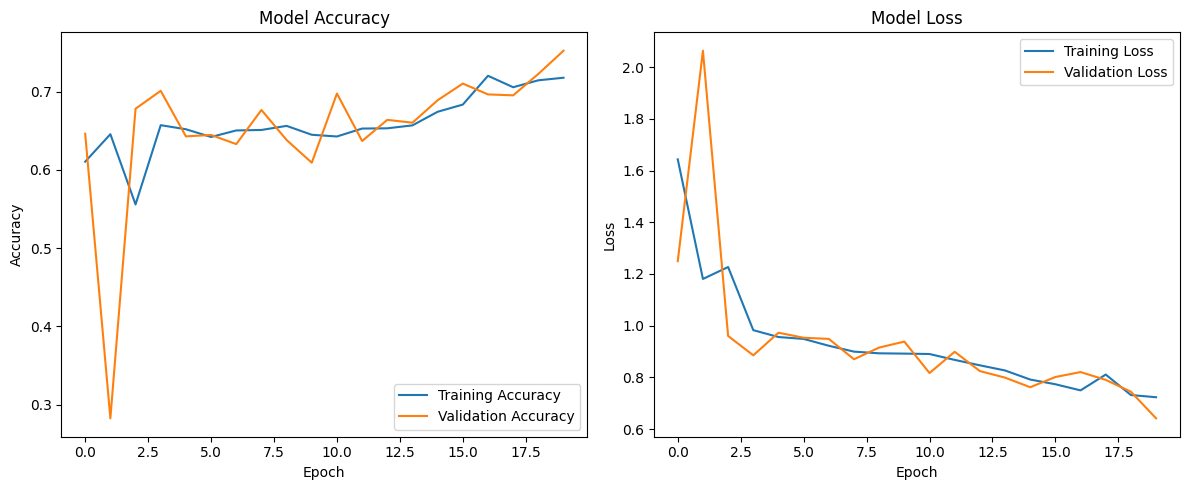

In [20]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [21]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...


2025-08-24 17:05:58.173963: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6850 - loss: 0.7788

Test Loss: 0.7699
Test Accuracy: 0.6870


### Model Saving and Prediction

In [22]:
model.save('models/car_segmentation_unet.keras')

In [23]:
loaded_model = tf.keras.models.load_model('models/car_segmentation_unet.keras')

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0
    

    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img
    

In [26]:
def predict_and_visualize(image_path, model):

   
    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)
    
    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')
    
    plt.show()

2025-08-24 17:05:59.605176: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


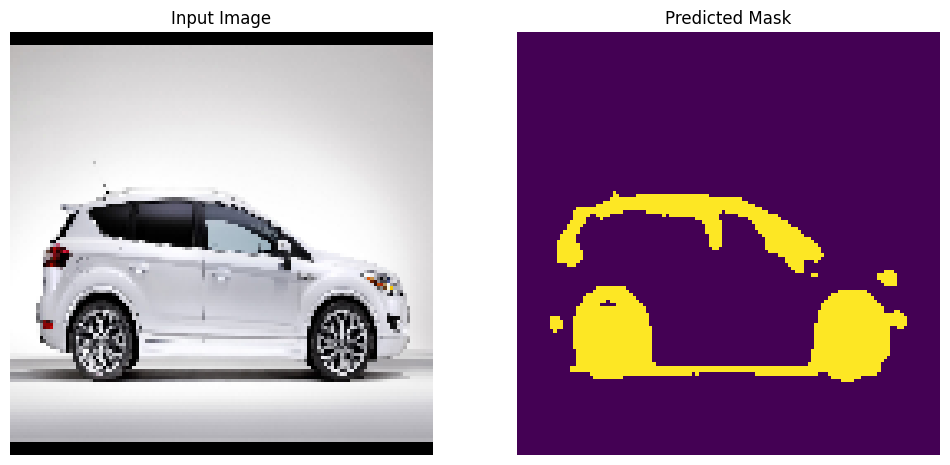

In [27]:
test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, loaded_model)

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)

    
    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]
    
    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))
    
    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]
        
        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")
        
        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis') 
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2025-08-24 17:06:00.295251: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


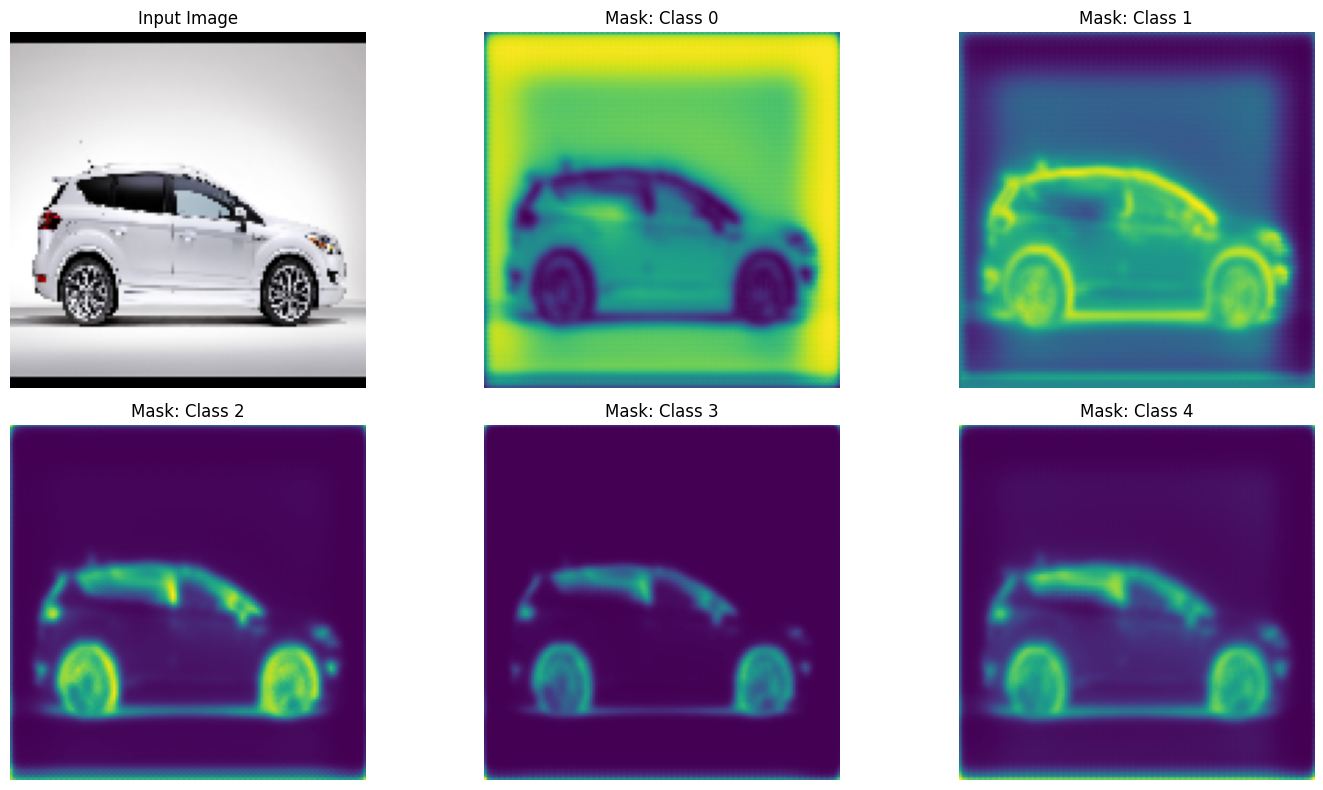

In [29]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2025-08-24 17:06:32.530428: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


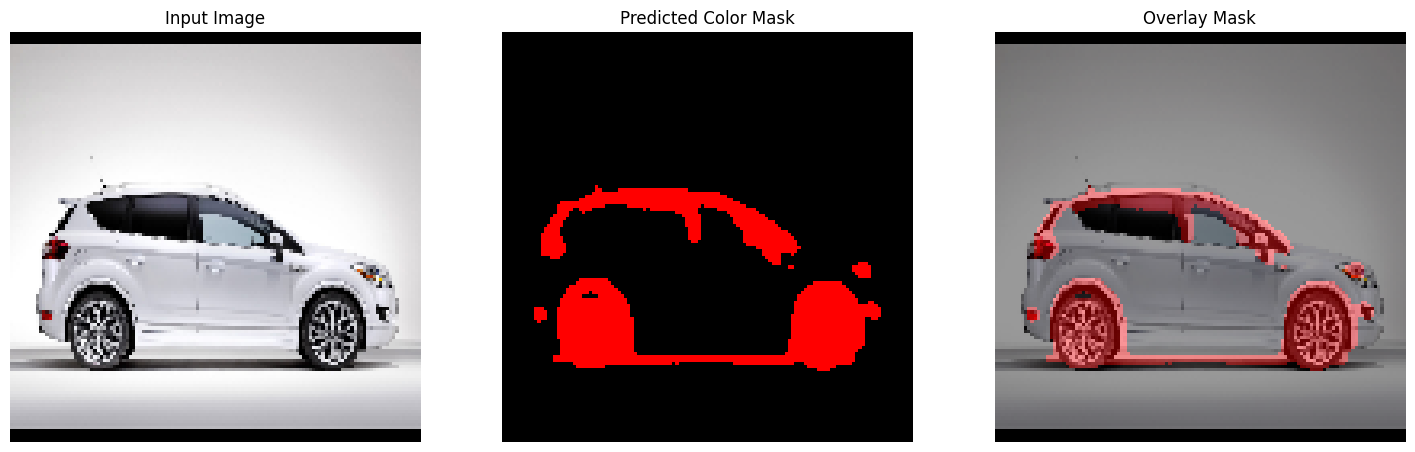

In [31]:
import numpy as np
import cv2 

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
    [0, 0, 255],     # Class 3: Blue
    [255, 255, 0]    # Class 4: Yellow
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()
    
    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)
    
    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)
    
    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)
    
    # Display the results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()


test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)